In [2]:
from retry import retry
import json
import praw
import datetime
from collections import defaultdict
import json
from tqdm import tqdm
from prawcore.exceptions import Forbidden
import matplotlib.pyplot as plt
import os
from typing import List
import time
import os
import json
import pandas as pd
from openpyxl import Workbook
import csv

# Focus on top 1000 in every community

We'll track all of their activity accross all reddit, without their musical community activity.


In [3]:
def write_or_append_to_json_file(data_dict, file_path):
    file_size = 0
    if os.path.isfile(file_path):
        file_size = os.stat(file_path).st_size

    with open(file_path, 'ab') as fp:
        if file_size > 0:
            fp.seek(file_size - 2)
            fp.truncate()
            fp.write(b',')
        fp.write(json.dumps(data_dict).encode('utf-8'))

    fp.close()

In [37]:
with open('data/non_intersection_authors_2.json', 'r') as file:
    top_commenters_by_community = json.load(file)

In [ ]:
# reddit = praw.Reddit(
#     client_id='w7tYilptWAf8X_bSFgw1ew',
#     client_secret='SFLZmwK6Lcqj86s-WH98Sh3L4kwm4w',  # @TODO - don't push to git
#     user_agent='desktop:eliranse-musical-preferences:v1.0.0 (by /u/eliranse)',
# )

reddit = praw.Reddit(
    client_id='1LxqtJft3LM75yx2MgPqAA',
    client_secret='W8roMmNh_uBIFaJj4LzMgoTOWN8fow',
    user_agent='desktop:eliranse-musical-preferences-oauth:v1.0.0 (by /u/eliranse)',
    username='eliranse',
    password='SGK.3Bwb9a!6i!2'
)


# @retry((Forbidden, Exception), delay=2, tries=3)
def fetch_user_activity(username):
    current_date = datetime.datetime.utcnow()
    one_year_ago = current_date - datetime.timedelta(days=900)
    subreddit_data = defaultdict(
        lambda: {"count": 0, "submissions": [], "comments": []})
    user = reddit.redditor(username)
    for submission in paginate_results(user.submissions.new, limit=None):
        if submission.created_utc < one_year_ago.timestamp():
            break
        subreddit_name = submission.subreddit.display_name
        subreddit_data[subreddit_name]["count"] += 1
        if submission.selftext:
            subreddit_data[subreddit_name]["submissions"].append({
                "title": submission.title,
                "body": submission.selftext,
                "domain": submission.domain,
                "date": submission.created_utc
            })

    for comment in paginate_results(user.comments.new, limit=None):
        if comment.created_utc < one_year_ago.timestamp():
            break
        subreddit_name = comment.subreddit.display_name
        subreddit_data[subreddit_name]["count"] += 1
        subreddit_data[subreddit_name]["comments"].append({
            "body": comment.body,
            "date": datetime.datetime.fromtimestamp(comment.created_utc).isoformat()
        })
    return subreddit_data


def paginate_results(fetch_function, limit=None):
    results = []
    last_item = None

    while True:
        if last_item is None:
            new_results = list(fetch_function(limit=limit))
        else:
            new_results = list(fetch_function(
                limit=limit, params={'after': last_item}))
        if not new_results:
            break
        results.extend(new_results)
        last_item = new_results[-1].name
    return results

In [6]:
def mark_community_as_done(community_name: str):
    try:
        with open('done_communities.json', 'r') as f:
            done_communities = json.load(f)
            done_communities.append(community_name)
    except FileNotFoundError:
        done_communities = []

    with open('done_communities.json', 'w') as f:
        json.dump(done_communities, f)
    return done_communities

In [ ]:
for community in top_commenters_by_community:
    if community != 'hiphopheads':
        continue
    print(f"Working on community: {community}")
    count = 0
    for username in tqdm(top_commenters_by_community[community]):
        file_path = os.path.join(
            "data", "detailed_data", community, f"{username}.json")
        if not os.path.isfile(file_path):
            try:
                user_activity = fetch_user_activity(username)
                print('success!!!')
            except Exception as e:
                continue
            write_or_append_to_json_file(user_activity, file_path)
            print(f'wrote another file! {count+1}')
        count += 1
        if count >= 1000:
            break
    done_communities = mark_community_as_done(community)

---


In [43]:
def count_empty_json_files(folder_path):
    non_empty_count = 0
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and file_path.endswith('.json'):
            with open(file_path, 'r', encoding='utf-8') as file:
                try:
                    data = json.load(file)
                    if data:
                        non_empty_count += 1
                except json.JSONDecodeError:
                    print(f"Error loading JSON from file: {file_path}")
    return non_empty_count


for community_name in ['Metal', 'electronicmusic', 'indieheads', 'hiphopheads', 'classicalmusic']:
    folder_path = os.path.join('data', 'detailed_data', community_name)
    non_empty_files_count = count_empty_json_files(folder_path)
    print(
        f"members of {community_name}: {non_empty_files_count}")

members of Metal: 896
members of electronicmusic: 778
members of indieheads: 952
members of hiphopheads: 998
members of classicalmusic: 877


In [36]:
import copy
with open('data/non_intersection_authors.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
    data_clone = copy.deepcopy(data)
    for community in data:
        for username in tqdm(data[community]):
            if os.path.isfile(f'data/detailed_data/{community}/{username}.json'):
                data_clone[community].pop(username)
write_or_append_to_json_file(
    data_clone, 'data/non_intersection_authors_2.json')

100%|██████████| 85705/85705 [00:06<00:00, 12939.23it/s]


In [3]:
main_folder_path = '/Users/eliran.shemtov/DevProjects/Musical-Preferences/Musical-Preferences-And-Textual-Expression/new_detailed_data'
header = ['musical_genre_community', 'username', 'subreddit 1 name', 'subreddit 1 count',
          'subreddit 2 name', 'subreddit 2 count', 'subreddit 3 name', 'subreddit 3 count',
          'subreddit 4 name', 'subreddit 4 count', 'subreddit 5 name', 'subreddit 5 count',
          'subreddit 6 name', 'subreddit 6 count', 'subreddit 7 name', 'subreddit 7 count',
          'subreddit 8 name', 'subreddit 8 count', 'subreddit 9 name', 'subreddit 9 count',
          'subreddit 10 name', 'subreddit 10 count']
data_rows = []

for genre_folder in os.listdir(main_folder_path):
    genre_folder_path = os.path.join(main_folder_path, genre_folder)
    if genre_folder.startswith('.'):
        continue

    for filename in os.listdir(genre_folder_path):
        file_path = os.path.join(genre_folder_path, filename)
        if filename.startswith('.'):
            continue

        username = os.path.splitext(filename)[0]
        with open(file_path, 'r') as json_file:
            json_data = json.load(json_file)

        if not json_data:
            continue

        subreddit_data = json_data.keys()
        subreddit_data = [
            subreddit for subreddit in subreddit_data if subreddit != genre_folder]
        sorted_subreddits = sorted(
            subreddit_data, key=lambda x: json_data[x]['count'], reverse=True)
        top_subreddits = sorted_subreddits[:10]

        row = [genre_folder, username]
        for subreddit in top_subreddits:
            row.append(subreddit)
            row.append(json_data[subreddit]['count'])

        data_rows.append(row)

csv_path = '/Users/eliran.shemtov/DevProjects/Musical-Preferences/Musical-Preferences-And-Textual-Expression/output.csv'
with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(header)
    writer.writerows(data_rows)

In [ ]:
main_folder_path = '/Users/eliran.shemtov/DevProjects/Musical-Preferences/Musical-Preferences-And-Textual-Expression/new_detailed_data'
for genre_folder in os.listdir(main_folder_path):
    genre_folder_path = os.path.join(main_folder_path, genre_folder)
    if genre_folder.startswith('.'):
        continue
    subreddit_counts = {}

    for filename in os.listdir(genre_folder_path):
        file_path = os.path.join(genre_folder_path, filename)
        if filename.startswith('.'):
            continue
        with open(file_path, 'r') as json_file:
            json_data = json.load(json_file)
        subreddit_data = json_data.keys()
        subreddit_data = [
            subreddit for subreddit in subreddit_data if subreddit != genre_folder]
        for subreddit in subreddit_data:
            count = json_data[subreddit]['count']
            if count >= 1:
                subreddit_counts[subreddit] = subreddit_counts.get(
                    subreddit, 0) + 1
    sorted_counts = sorted(subreddit_counts.items(),
                           key=lambda x: x[1], reverse=True)
    print("Musical Genre: ", genre_folder)
    for subreddit, count in sorted_counts:
        print("Subreddit: ", subreddit)
        print("Number of Users: ", count)
        print("---")
    print("==========")

In [15]:
main_folder_path = '/Users/eliran.shemtov/DevProjects/Musical-Preferences/Musical-Preferences-And-Textual-Expression/new_detailed_data'
community_data = {}

for genre_folder in os.listdir(main_folder_path):
    genre_folder_path = os.path.join(main_folder_path, genre_folder)
    if genre_folder.startswith('.'):
        continue
    subreddit_counts = {}

    for filename in os.listdir(genre_folder_path):
        file_path = os.path.join(genre_folder_path, filename)
        if filename.startswith('.'):
            continue
        with open(file_path, 'r') as json_file:
            json_data = json.load(json_file)

        subreddit_data = json_data.keys()
        subreddit_data = [
            subreddit for subreddit in subreddit_data if subreddit != genre_folder]
        for subreddit in subreddit_data:
            count = json_data[subreddit]['count']
            if count >= 1:
                subreddit_counts[subreddit] = subreddit_counts.get(
                    subreddit, 0) + 1

    sorted_counts = sorted(subreddit_counts.items(),
                           key=lambda x: x[1], reverse=True)
    community_data[genre_folder] = sorted_counts

workbook = Workbook()
for community, subreddit_counts in community_data.items():
    df = pd.DataFrame(subreddit_counts, columns=[
                      'Subreddit', 'Number of Users'])
    sheet = workbook.create_sheet(title=community)
    sheet.append(['Subreddit', 'Number of Users'])
    for row in df.itertuples(index=False):
        sheet.append(row)
workbook.remove(workbook['Sheet'])
workbook.save('analysis/community_summary.xlsx')

Top subreddits - the number is the count of users that commented or posted at least once in a subreddit


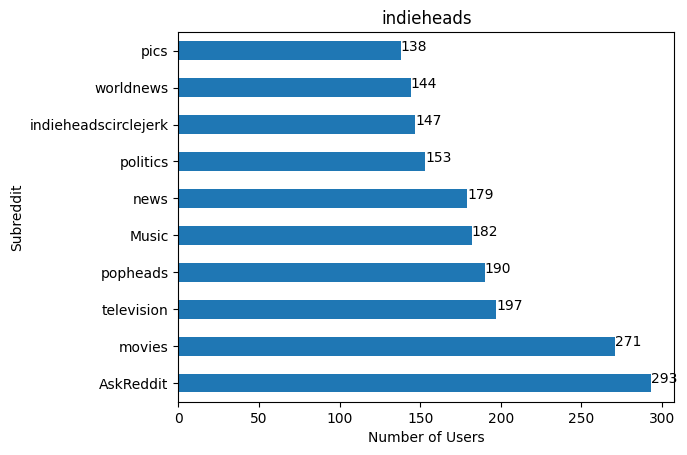

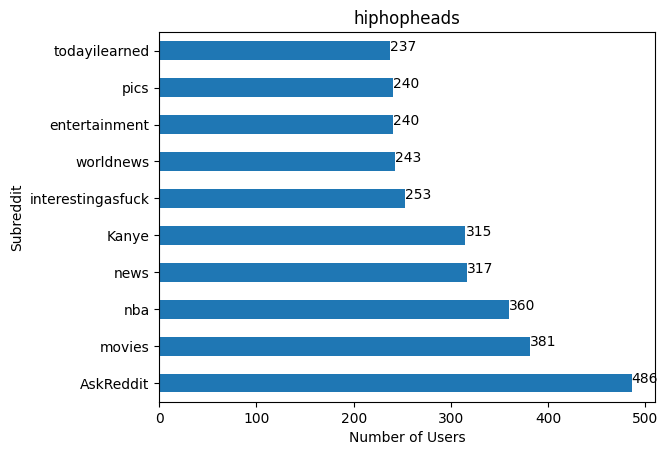

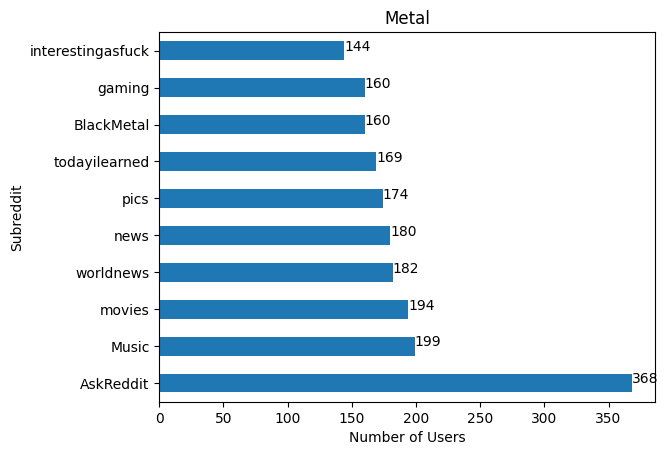

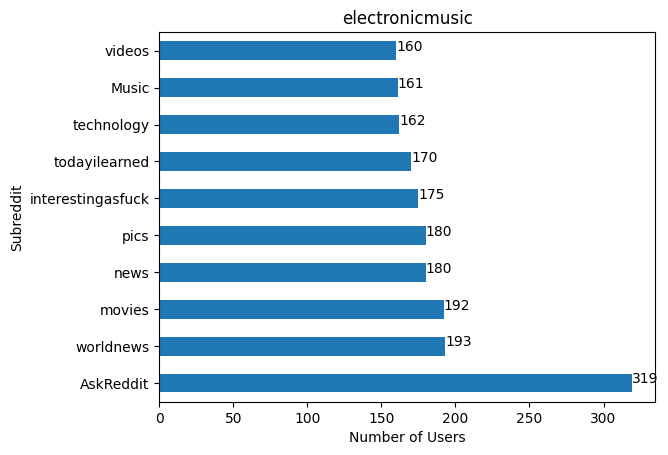

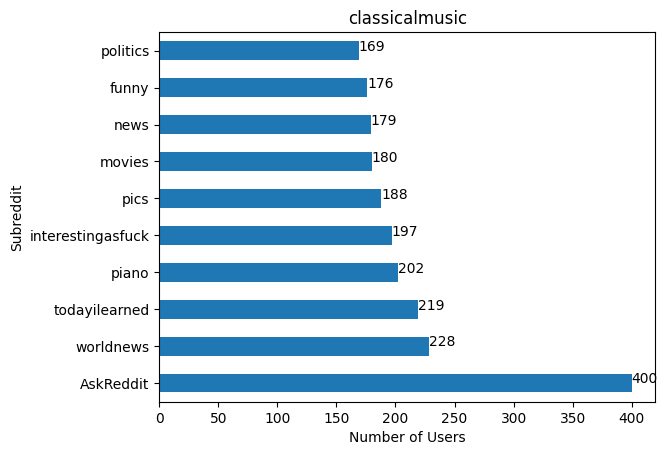

In [25]:
print('Top subreddits - the number is the count of users that commented or posted at least once in a subreddit')
xlsx_file = 'analysis/community_summary.xlsx'
xl = pd.ExcelFile(xlsx_file)
max_subreddits = 10

for sheet_name in xl.sheet_names:
    df = xl.parse(sheet_name)
    df.sort_values(by='Number of Users', ascending=False, inplace=True)
    top_subreddits = df.head(max_subreddits)
    top_subreddits.set_index('Subreddit', inplace=True)
    ax = top_subreddits.plot(kind='barh', legend=False)
    ax.set_xlabel('Number of Users')
    ax.set_ylabel('Subreddit')
    ax.set_title(sheet_name)
    for i, value in enumerate(top_subreddits['Number of Users']):
        ax.text(value, i, str(value))

    plt.show()

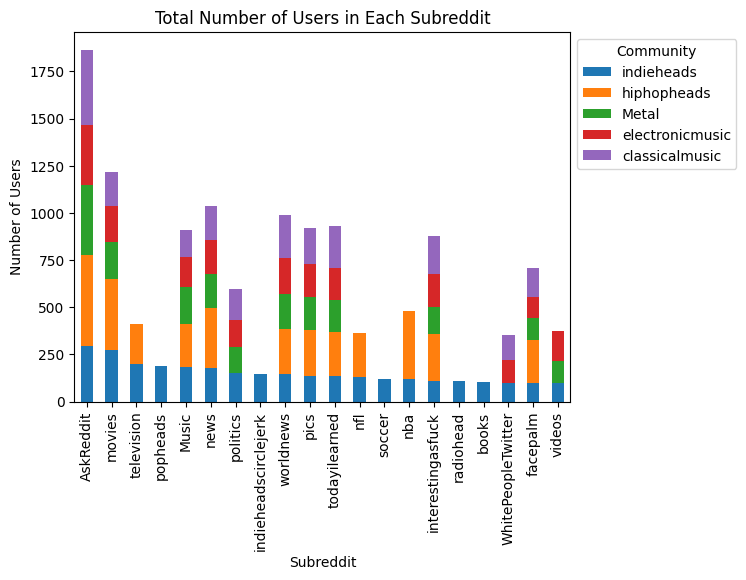

In [31]:
xlsx_file = 'analysis/community_summary.xlsx'
xl = pd.ExcelFile(xlsx_file)

max_subreddits = 20
data = pd.DataFrame()

for sheet_name in xl.sheet_names:
    df = xl.parse(sheet_name)
    df.sort_values(by='Number of Users', ascending=False, inplace=True)
    top_subreddits = df.head(max_subreddits)
    data[sheet_name] = top_subreddits.set_index('Subreddit')['Number of Users']

ax = data.plot(kind='bar', stacked=True)
ax.set_xlabel('Subreddit')
ax.set_ylabel('Number of Users')
ax.set_title('Total Number of Users in Each Subreddit')
ax.legend(title='Community', bbox_to_anchor=(1, 1), loc='upper left')

plt.show()